In [48]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

# Open the ROOT files
events = uproot.open("/fast_scratch_1/jbohm/cell_particle_deposit_learning/delta/delta_root_files/delta_full.root" + ":EventTree")
cell_geo_tree = uproot.open("/data/atlas/data/rho_delta/rho_small.root" + ":CellGeo")

# Find the first event with 8 or more truth particles
min_parts = 4
n_truth_part = events["nTruthPart"].array()
first_index = ak.firsts(ak.where(n_truth_part >= min_parts))
if not ak.is_valid(first_index):
    raise ValueError(f"No event with {min_parts} or more truth particles was found.")
print(f"Event {first_index} has {n_truth_part[first_index]} truth particles.")

# Load data for the specific event
event_data = events.arrays(entry_start=first_index[0], entry_stop=first_index[0] + 1)
cell_geo_data = cell_geo_tree.arrays()

# Convert eta, phi to cartesian coordinates
def eta_phi_to_xyz(eta, phi, rPerp):
    theta = 2 * np.arctan(np.exp(-eta))
    return rPerp * np.cos(phi), rPerp * np.sin(phi), rPerp / np.tan(theta)

# Extract cell IDs and geometric data
cell_ids = cell_geo_data["cell_geo_ID"][0]
eta, phi, rPerp = cell_geo_data["cell_geo_eta"][0], cell_geo_data["cell_geo_phi"][0], cell_geo_data["cell_geo_rPerp"][0]

# Convert eta, phi to cartesian coordinates
x, y, z = eta_phi_to_xyz(eta, phi, rPerp)

# Create a dictionary to map cell IDs to their x, y, z coordinates
cell_id_to_xyz = {cell_id: (x_val, y_val, z_val) for cell_id, x_val, y_val, z_val in zip(cell_ids, x, y, z)}

# Process Energy Deposits
# Load energy deposits and cell IDs from the event
hits_truth_id = event_data["cluster_cell_ID"][0]  # Update this if the structure is different
hits_truth_e = event_data["cluster_cell_E"][0] * 1000  # Update and adjust units if necessary
print(f"hits_truth_id: {hits_truth_id}")
print(f"hits_truth_e: {hits_truth_e}")

# Ensure that we're working with flat arrays for zip operation
hits_truth_id_flat = ak.flatten(hits_truth_id)
hits_truth_e_flat = ak.flatten(hits_truth_e)

# Filter cells with no energy deposited and create a dictionary mapping cell IDs to energy deposits
cell_id_to_energy = {cell_id: energy for cell_id, energy in zip(hits_truth_id_flat, hits_truth_e_flat) if energy > 0}
print(f"cell_id_to_energy: {cell_id_to_energy}")

# Determine Color Based on Energy Deposit and Particle Type
# Define color maps for energy deposit and particle types
energy_color_map = plt.get_cmap('viridis')  # Change as needed
particle_color_map = {5: 'yellow', 6: 'blue', '5_and_6': 'green', 'other': 'red'}

# Load particle types (Update this if the structure is different)
if "cluster_cell_hitsTruthIndex" in event_data.fields:
    hits_truth_index = event_data["cluster_cell_hitsTruthIndex"][0][0]
else:
    hits_truth_index = ak.Array([])  # Fallback to an empty array if data is not present

# Assign colors based on energy deposit and particle type
cell_id_to_color_energy = {cell_id: energy_color_map(energy / max(cell_id_to_energy.values())) for cell_id, energy in cell_id_to_energy.items()}
default_color = 'red'  # Default color for undefined particle types
cell_id_to_color_particle = {
    cell_id: particle_color_map.get(particle_type[0], default_color) if len(particle_type) == 1 else particle_color_map.get('5_and_6', default_color)
    for cell_id, particle_type in zip(hits_truth_id_flat, hits_truth_index)
    if cell_id in cell_id_to_energy  # Ensure the cell has an energy deposit
}

# Prepare the data for plotting
# Filtering the coordinates and assigning colors for cells with energy deposits
xyz = np.array([cell_id_to_xyz[cell_id] for cell_id in cell_id_to_energy.keys()])

# Normalize energy values on a log scale for color mapping
energy_norm = LogNorm(vmin=min(cell_id_to_energy.values()), vmax=max(cell_id_to_energy.values()))

# Map energy values to colors using the log scale
colors_energy = [energy_color_map(energy_norm(energy)) for energy in cell_id_to_energy.values()]

colors_particle = np.array([cell_id_to_color_particle.get(cell_id, default_color) for cell_id in cell_id_to_energy.keys()])

# Determine cells without energy deposits
all_cell_ids = set(cell_ids)
cells_with_energy = set(cell_id_to_energy.keys())
cells_without_energy = all_cell_ids - cells_with_energy

# Get the xyz coordinates for cells without energy deposits
xyz_no_energy = np.array([cell_id_to_xyz[cell_id] for cell_id in cells_without_energy])



# Print final results for inspection
print(f"xyz: {xyz}")
print(f"colors_energy: {colors_energy}")
print(f"colors_particle: {colors_particle}")

Event [2] has [4] truth particles.
hits_truth_id: [[759185562, 759185560, 759185050, ..., 757228582, 757230118, 1141130496], ...]
hits_truth_e: [[1.74e+04, 8.66e+03, 991, 4.49e+03, ..., 31.3, 11.5, 11.2, 6.79], ..., [...]]
cell_id_to_energy: {759185562: 17407.887, 759185560: 8663.496, 759185050: 991.05383, 759186074: 4492.0366, 759185048: 1372.2031, 759186072: 3241.782, 759185052: 890.08716, 757202982: 25.092455, 757203494: 62.19105, 757204006: 67.861275, 757204518: 112.986244, 757205030: 288.31387, 757205542: 892.58624, 757206054: 421.31506, 757206566: 269.87985, 761274522: 374.62845, 759185558: 730.8749, 759185046: 805.52985, 759186070: 784.68823, 761274520: 527.76965, 759186584: 862.90454, 759186582: 237.46631, 759184536: 263.17508, 759184534: 124.721794, 759184538: 104.98485, 757198886: 34.08835, 757199398: 46.04422, 757199910: 41.038006, 757200422: 48.155483, 757200934: 54.874466, 757201446: 41.038006, 757201958: 54.874466, 757202470: 39.141823, 761274008: 291.8611, 759184540: 316

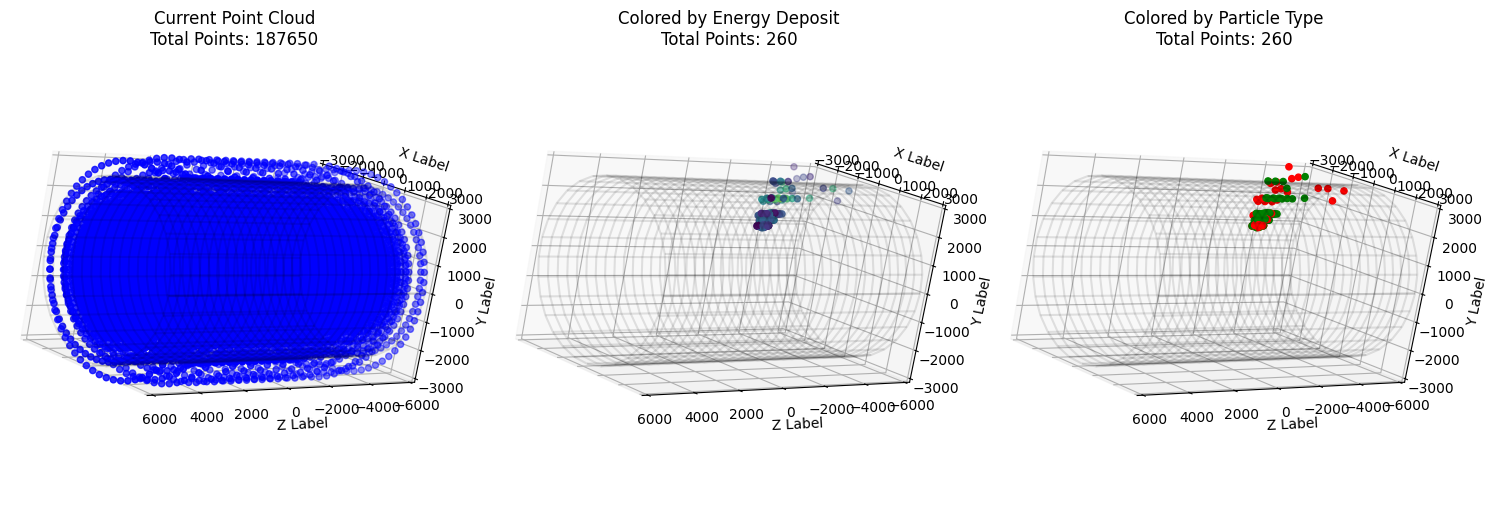

In [49]:
# Define the range for x, y, z axis
x_limits = (-3000, 3000)
y_limits = (-3000, 3000)
z_limits = (-6000, 6000)
el = 45
az = 15
ro = 90

# Define cylinder characteristics
r = 3000  # radius
h = 12000  # height
# Cylinder
theta = np.linspace(0, 2 * np.pi, 30)
z_cylinder = np.linspace(-6000, 6000, 30)
theta_grid, z_grid = np.meshgrid(theta, z_cylinder)
x_cylinder = r * np.cos(theta_grid)
y_cylinder = r * np.sin(theta_grid)

# 1. Plot the Current Point Cloud
fig = plt.figure(figsize=(15, 5))  # Adjust the figure size as needed
ax1 = fig.add_subplot(131, projection='3d')
# Plot cylinder as a mesh
ax1.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
ax1.scatter(x, y, z, color='b')
ax1.set_title(f'Current Point Cloud\nTotal Points: {len(x)}')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.set_zlim(z_limits)
ax1.set_box_aspect([1,1,2])  # Aspect ratio is 1:1:2
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.view_init(elev=el, azim=az, roll=ro)

# 2. Plot Point Cloud Colored by Total Adjusted Energy Deposit
ax2 = fig.add_subplot(132, projection='3d')
#ax2.scatter(xyz_no_energy[:, 0], xyz_no_energy[:, 1], xyz_no_energy[:, 2], color='gray', alpha=0.05)  # Cells without energy in gray
ax2.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
scatter = ax2.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_energy)  # Cells with energy in color
ax2.set_title(f'Colored by Energy Deposit\nTotal Points: {len(xyz)}')
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax2.set_zlim(z_limits)
ax2.set_box_aspect([1,1,2])
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.view_init(elev=el, azim=az, roll=ro)


# 3. Plot Point Cloud Colored by the Particle Type
ax3 = fig.add_subplot(133, projection='3d')
#ax3.scatter(xyz_no_energy[:, 0], xyz_no_energy[:, 1], xyz_no_energy[:, 2], color='gray', alpha=0.05)  # Cells without energy in gray
ax3.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
scatter = ax3.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_particle, alpha=1.0)  # Particle colors constant
ax3.set_title(f'Colored by Particle Type\nTotal Points: {len(xyz)}')
ax3.set_xlim(x_limits)
ax3.set_ylim(y_limits)
ax3.set_zlim(z_limits)
ax3.set_box_aspect([1,1,2])
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.view_init(elev=el, azim=az, roll=ro)


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
